In [1]:
from CANCER import *


In [2]:
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader

class Trainer:
    def __init__(self, model, dataset, batch_size = 32, train_rate=0.7, val_rate=0.2, test_rate=0.1):
        self.model = model
        self.dataset = dataset

        train_data, validation_data, test_data = self.__split_dataset(train_rate, val_rate, test_rate)
        self.train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    def train(self, epochs = 100, learning_rate = 0.01, weight_decay=0.01, eps = 1e-5, debug=False, print_every=10, device='cpu'):
        self.model.to(device)
        
        if debug:
            torch.autograd.set_detect_anomaly(True)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay, eps=eps)
        criterion = torch.nn.CrossEntropyLoss()

        train_losses = []
        train_acc = []
        val_losses = []
        val_accs = []

        for epoch in range(epochs):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0
            for data in self.train_loader:
                self.model.train()
                data = data.to(device)
                optimizer.zero_grad()
                _, out = self.model(data)
                loss = criterion(out, data.y)
                total_loss += loss / len(self.train_loader)
                acc += self.accuracy(out.argmax(dim=1), data.y) / len(self.train_loader)
                loss.backward()
                optimizer.step()

                val_loss, val_acc = self.test(val_mode=True, device=device)

            train_losses.append(total_loss)
            train_acc.append(acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            if epoch % print_every == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
                        f'| Train Acc: {acc*100:>5.2f}% '
                        f'| Val Loss: {val_loss:.5f} '
                        f'| Val Acc: {val_acc*100:.5f}%')
        history = {'train_loss': train_losses, 'train_acc': train_acc, 'val_loss': val_losses, 'val_acc': val_accs}
        return history

    @torch.no_grad()
    def test(self, val_mode = False, device='cpu'):
        criterion = torch.nn.CrossEntropyLoss()
        self.model.eval()
        loss = 0
        acc = 0

        loader = self.val_loader if val_mode else self.test_loader
        for data in loader:
            data.to(device)
            _, out = self.model(data)
            loss += criterion(out, data.y) / len(loader)
            acc += self.accuracy(out.argmax(dim=1), data.y) / len(loader)
        return loss, acc

    def accuracy(self, pred_y, y):
        """Calculate accuracy."""
        return ((pred_y == y).sum() / len(y)).item()
    
    
    def __split_dataset(self, dataset, train_rate = 0.7, val_rate = 0.2, test_rate = 0.1):
        dataset_len = len(dataset)
        grouped_data = {}
        
        data_train = []
        data_validation = []
        data_test = []

        for i in range(dataset_len):
            data = dataset[i]
            if data.y.item() not in grouped_data:
                grouped_data[data.y.item()] = [data]
            else:
                grouped_data[data.y.item()].append(data)

        for group, data in grouped_data.items():
            train_data_group = data[:int(len(data)*train_rate)]
            validation_data_group = data[int(len(data)*train_rate):int(len(data)*(train_rate+val_rate))]
            test_data_group = data[int(len(data)*(train_rate+val_rate)):]            
        
            data_train.extend(train_data_group)
            data_validation.extend(validation_data_group)
            data_test.extend(test_data_group)

        return data_train, data_validation, data_test


In [3]:
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv, GINEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
import torch.nn as nn

class PrintLayer(nn.Module):
    def __init__(self, name):
        super().__init__()
        self.name = name

    def forward(self, x):
        print("{} torch.isfinite(x).all(): {}, min. {:.5f}, max. {:.5f}".format(
            self.name, torch.isfinite(x).all(), x.min(), x.max()))
        return x

class GINCustomConv(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GINCustomConv, self).__init__()
        self.conv = GINConv(
            Sequential(
                Linear(dim_in, dim_h),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_out),
                ReLU()
            ),
            train_eps=True
        )    
    def forward(self, X, edge_index):
        return self.conv(X, edge_index)
        

class GIN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, layer_num=3):
        super(GIN, self).__init__()
        assert layer_num >= 1
        self.layer_num = layer_num
        if layer_num == 1:
            self.conv_in = GINCustomConv(dim_in, dim_h, dim_h)
        elif layer_num >= 2:
            self.conv_in = GINCustomConv(dim_in, dim_h, dim_h)
            self.conv = nn.ModuleList([GINCustomConv(dim_h, dim_h, dim_h) for _ in range(layer_num-1)])
        
        self.lin1 = Linear(dim_h * layer_num, dim_h * layer_num)
        self.lin2 = Linear(dim_h * layer_num, dim_out)

    def __readout(self, embedded_layers, batch):
        embedded_list = []
        for h in embedded_layers:
            temp_read = global_add_pool(h, batch)
            embedded_list.append(temp_read)
        graph_embedded = torch.cat(embedded_list, dim=1)
        return graph_embedded

    def __classification(self, embedded):
        h = self.lin1(embedded)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        return h, F.log_softmax(h, dim=1)
 
    def __embedding(self, data):
        embedded_layers = []
        h = self.conv_in(data.x, data.edge_index)
        embedded_layers.append(h)
        for conv in self.conv:
            h = conv(h, data.edge_index)
            embedded_layers.append(h)
        return embedded_layers

    def forward(self, data):
        if self.layer_num == 1:
            h = self.conv_in(data.x, data.edge_index)
            h = global_add_pool(h, data.batch)
            return self.__classification(h)

        # Node embeddings
        embedded_layers = self.__embedding(data)
        graph_embedded = self.__readout(embedded_layers, data.batch)
        return self.__classification(graph_embedded)



In [7]:
# full = MyDataSet(
#     NLabel.FULL.filename, 
#     [
#         ELabel.BREAST_CANCER,
#         ELabel.CANCER, 
#         ELabel.COLORECTAL_CANCER,
#         ELabel.ENDOMETRIAL_CANCER, 
#         ELabel.GILOMA, 
#         ELabel.RENAL_CELL_CARCINOMA
#     ], 
#     detail=True, 
#     drop_y_threshold=1
# )

# full_dataset = full.make_dataset()
brac = MyDataSet(
                [NLabel.BRAC_TCGA.filename, NLabel.BRAC_TCGA_PAN_CAN_ATLAS.filename, NLabel.BRAC_TCGA_PUB2015.filename], 
                [ELabel.BREAST_CANCER],
                drop_y_threshold=1,
                reverse = True,
                # self_edge = True
            )
brac_dataset = brac.make_dataset_onehot_column()

yset  15


In [8]:
gin = GIN(brac_dataset.num_features, 32, brac_dataset.num_classes, layer_num=2)
trainer = Trainer(gin, brac_dataset, batch_size=32)

In [9]:
history = trainer.train(
                        epochs=100, 
                        print_every=10, 
                        learning_rate = 0.00005, 
                        weight_decay=0.01,
                        eps=1e-5,
                        device='cuda'
                    )
test_loss, test_acc = trainer.test(
    device='cuda'
)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch   0 | Train Loss: 13.47 | Train Acc: 13.01% | Val Loss: 3.26994 | Val Acc: 69.46272%
Epoch  10 | Train Loss: 1.26 | Train Acc: 67.28% | Val Loss: 0.90041 | Val Acc: 76.10432%
Epoch  20 | Train Loss: 1.07 | Train Acc: 71.67% | Val Loss: 0.79231 | Val Acc: 78.28164%
Epoch  30 | Train Loss: 0.95 | Train Acc: 74.42% | Val Loss: 0.74889 | Val Acc: 79.99687%
Epoch  40 | Train Loss: 0.87 | Train Acc: 77.45% | Val Loss: 0.71989 | Val Acc: 80.74875%
Epoch  50 | Train Loss: 0.86 | Train Acc: 77.35% | Val Loss: 0.69009 | Val Acc: 81.82174%
Epoch  60 | Train Loss: 0.79 | Train Acc: 79.01% | Val Loss: 0.67976 | Val Acc: 81.82174%
Epoch  70 | Train Loss: 0.76 | Train Acc: 79.81% | Val Loss: 0.66807 | Val Acc: 82.21335%
Epoch  80 | Train Loss: 0.70 | Train Acc: 80.24% | Val Loss: 0.64487 | Val Acc: 83.95207%
Epoch  90 | Train Loss: 0.71 | Train Acc: 80.81% | Val Loss: 0.63136 | Val Acc: 84.53164%
Test Loss: 0.7759, Test Acc: 0.8145


{'train_loss': [tensor(13.4735, device='cuda:0', grad_fn=<AddBackward0>), tensor(6.4019, device='cuda:0', grad_fn=<AddBackward0>), tensor(4.7011, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.6063, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.9245, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.3265, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.8832, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.5734, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.4556, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.3402, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.2648, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.2013, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.2094, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1714, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1263, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1338, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.1027, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.0872,

Text(0.5, 0, 'Epoch')

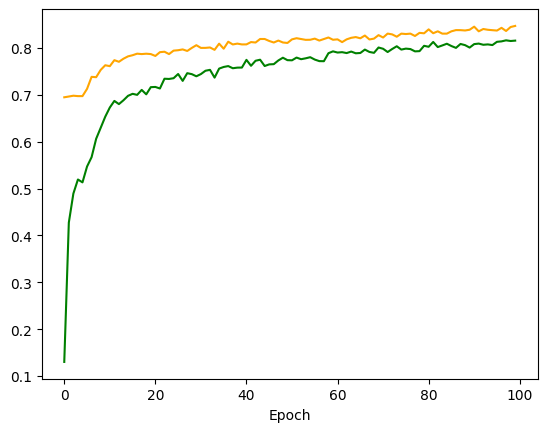

In [10]:
import matplotlib.pyplot as plt

for idx in range(len(history['train_loss'])):
    if type(history['train_loss'][idx]) == torch.Tensor:
        history['train_loss'][idx] = history['train_loss'][idx].cpu().item()
    if type(history['val_loss'][idx]) == torch.Tensor:
        history['val_loss'][idx] = history['val_loss'][idx].cpu().item()
    if type(history['train_acc'][idx]) == torch.Tensor:
        history['train_acc'][idx] = history['train_acc'][idx].cpu().item()
    if type(history['val_acc'][idx]) == torch.Tensor:
        history['val_acc'][idx] = history['val_acc'][idx].cpu().item()


plt.plot(history['train_loss'], label='train loss', color='red')
plt.plot(history['val_loss'], label='validation loss', color='blue')
# plt.plot(history['train_acc'], label='train accuracy', color='green')
# plt.plot(history['val_acc'], label='validation accuracy', color='orange')
plt.xlabel('Epoch')


In [76]:
class SimpleLinear(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(SimpleLinear, self).__init__()
        self.mlinear = Sequential(
                Linear(dim_in, dim_h, dtype=torch.float32),
                BatchNorm1d(dim_h),
                ReLU(),
                Linear(dim_h, dim_h, dtype=torch.float32),
                ReLU(),
                Dropout(p=0.5),
                Linear(dim_h, dim_out, dtype=torch.float32),
                ReLU()
            )
        
    def forward(self, data):
        # print(data.batch.shape)
        x = data.x.reshape((-1, 176))
        x = x.to(torch.float32)
        h = self.mlinear(x)
        return h, F.log_softmax(h, dim=1)
    
linear_3 = SimpleLinear(brac_dataset[0].x.shape[0], 32, full_dataset.num_classes)


In [77]:
simple_trainer = Trainer(linear_3 , full_dataset)
simple_trainer.train()
test_loss, test_acc = simple_trainer.test()
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch   0 | Train Loss: 2.57 | Train Acc: 43.95% | Val Loss: 2.25387 | Val Acc: 47.24702%
Epoch  10 | Train Loss: 2.03 | Train Acc: 49.96% | Val Loss: 1.95785 | Val Acc: 50.44643%
Epoch  20 | Train Loss: 1.99 | Train Acc: 51.42% | Val Loss: 1.93403 | Val Acc: 54.09226%
Epoch  30 | Train Loss: 1.95 | Train Acc: 51.49% | Val Loss: 1.96290 | Val Acc: 48.13988%
Epoch  40 | Train Loss: 1.92 | Train Acc: 52.62% | Val Loss: 1.88947 | Val Acc: 51.71131%
Epoch  50 | Train Loss: 1.92 | Train Acc: 52.54% | Val Loss: 1.92282 | Val Acc: 51.86012%
Epoch  60 | Train Loss: 1.93 | Train Acc: 52.29% | Val Loss: 1.87831 | Val Acc: 53.05060%
Epoch  70 | Train Loss: 1.92 | Train Acc: 51.95% | Val Loss: 1.88906 | Val Acc: 52.60417%
Epoch  80 | Train Loss: 1.92 | Train Acc: 51.32% | Val Loss: 1.89318 | Val Acc: 52.45536%
Epoch  90 | Train Loss: 1.90 | Train Acc: 52.29% | Val Loss: 1.86345 | Val Acc: 50.52083%
Test Loss: 1.9964, Test Acc: 0.5090
